In [1]:
# Nescessary imports

%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # supress tensorflow warnings


# import libraries
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import rotate

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

# set random seed
random.seed(42)

%load_ext autoreload

In [2]:
%autoreload 2
from classes.data_wraper import Dataset

In [3]:
# mount google drive if using google colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if 'google.colab' in sys.modules:
    root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks')
else:
    root_dir = os.getcwd()

if 'google.colab' in sys.modules:
    data_dir = os.path.join(root_dir, 'data')
else:
    data_dir = os.path.join(root_dir, 'data')

In [5]:
paths = {
    'FOVfiting2' : os.path.join(data_dir, 'mapsCeline_FOVfitting_2_pol-60.mat'),
    '3quadrants2' : os.path.join(data_dir, 'mapsCeline_3quadrants_2_pol-60.mat'),
    'FOVfiting3' : os.path.join(data_dir, 'mapsCeline_FOVfitting_3_pol-60.mat'),
    '3quadrants3' : os.path.join(data_dir, 'mapsCeline_3quadrants_3_pol-60.mat'),
    'FOVfiting4' : os.path.join(data_dir, 'mapsCeline_FOVfitting_4_pol-60.mat'),
    '3quadrants4' : os.path.join(data_dir, 'mapsCeline_3quadrants_4_pol-60.mat'),
    'FOVfiting5' : os.path.join(data_dir, 'mapsCeline_FOVfitting_5_pol-60.mat'),
    '3quadrants5' : os.path.join(data_dir, 'mapsCeline_3quadrants_5_pol-60.mat'),
    'FOVfiting6' : os.path.join(data_dir, 'mapsCeline_FOVfitting_6_pol-60.mat'),
    '3quadrants6' : os.path.join(data_dir, 'mapsCeline_3quadrants_6_pol-60.mat'),   
    'FOVfiting9' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9_pol-60.mat'),
    '3quadrants9' : os.path.join(data_dir, 'mapsCeline_3quadrants_9_pol-60.mat'),
    'FOVfiting9a' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9a_polNP.mat'),
    '3quadrants9a' : os.path.join(data_dir, 'mapsCeline_3quadrants_9a_polNP.mat')
}

In [6]:
calibration_maps = [paths['FOVfiting2'], paths['FOVfiting3'], paths['FOVfiting4'], paths['FOVfiting5'], paths['FOVfiting6'], paths['FOVfiting9'], paths['3quadrants2'], paths['3quadrants3']]
#calibration_maps = [paths['FOVfiting2']]
#calibration_maps = [map for map in paths.values()]
dataset = Dataset(calibration_maps)

Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_2_pol-60.mat
New lenght: 297
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_3_pol-60.mat
New lenght: 594
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_4_pol-60.mat
New lenght: 891
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_5_pol-60.mat
New lenght: 1188
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_6_pol-60.mat
New lenght: 1485
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_9_pol-60.mat
New lenght: 1782
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_3quadrants_2_pol-60.mat
New lenght: 2256
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_3quadrants_3_pol-60.mat
New lenght: 2730


In [7]:
dataset.preprocess_data()
dataset.crop_data(128)

In [48]:
X = np.stack((dataset.map1_list, dataset.map2_list, dataset.map3_list), axis=-1)
y = dataset.combined_list
azimut = dataset.azimut_list

In [9]:
print(np.min(X), np.max(X))

0.0 1.0


In [49]:
X_train, X_test, y_train, y_test, azimut_train, azimut_test = train_test_split(X, y, azimut, test_size=0.2, random_state=42)

In [11]:
def ssim_loss(y_true, y_pred):
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def ssim_mse_loss(y_true, y_pred):
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)

    # Compute SSIM loss
    ssim_loss = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    
    # Compute MSE loss
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    
    # Combine SSIM and MSE losses
    ssim_coef = 1
    mse_coef = 1000
    combined_loss = (ssim_coef * ssim_loss + mse_coef * mse_loss) / (ssim_coef + mse_coef)
    
    return combined_loss

In [12]:
%autoreload 2
from classes.UNet import UNet
from classes.Experiment import Experiment
from classes.utils import plot_map, plot_radial_profile

In [40]:
# Experiment
model = "UNet"
name = "MSE"

learning_rate = 0.001
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = [tf.keras.losses.MeanAbsoluteError()]
input_size = (X.shape[1], X.shape[2], 3)
output_size = (y.shape[1], y.shape[2], 1)
filters = [64,128,256]
dropout = 0.2

batch_size = 1
epochs = [20]

if 'google.colab' in sys.modules:
    csv_path = os.path.join(root_dir, 'results', model + '.csv')
else:
    csv_path = os.path.join(root_dir, 'results', model + '.csv')

In [41]:
experiment = Experiment(model, name, optimiser, learning_rate, loss, input_size, output_size, filters, dropout, epochs, batch_size, csv_path)

In [42]:
experiment.make(X_train, y_train, X_test, y_test)

Epoch 1/20
1965/1965 [==============================] - 17s 7ms/step - loss: 0.0178 - val_loss: 0.0167
Epoch 2/20
1965/1965 [==============================] - 13s 7ms/step - loss: 0.0153 - val_loss: 0.0141
Epoch 3/20
1965/1965 [==============================] - 13s 7ms/step - loss: 0.0129 - val_loss: 0.0148
Epoch 4/20
1965/1965 [==============================] - 13s 7ms/step - loss: 0.0101 - val_loss: 0.0159
Epoch 5/20
1965/1965 [==============================] - 13s 7ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 6/20
1965/1965 [==============================] - 13s 7ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 7/20
1965/1965 [==============================] - 13s 7ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 8/20
1965/1965 [==============================] - 13s 7ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 9/20
1965/1965 [==============================] - 13s 7ms/step - loss: 0.0054 - val_loss: 0.0100
Epoch 10/20
1965/1965 [==============================] - 13s 7ms/step - l

In [45]:
experiment.save_experiment_csv()

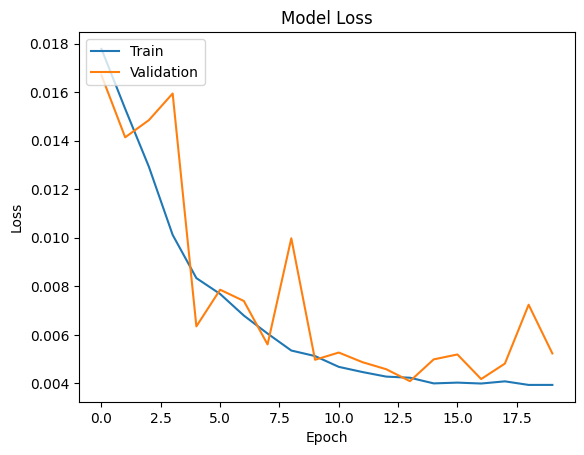

U-shaped graph saved at: unet_1.png


In [43]:
unet = experiment.get_model()

unet.plot_loss()

unet.summary(graph=True, graph_name="unet_1")

In [46]:
df = pd.read_csv(csv_path)
#df.head(len(df))
#df.describe()
df.iloc[-1]

Experiment number                            19
Name                                        MSE
Date                 2023-06-06 11:09:25.175972
Optimizer                                  Adam
Learning rate                             0.001
Loss                                       list
Input shape                       (128, 128, 3)
Output shape                      (128, 128, 1)
Filters                          [64, 128, 256]
Dropout                                     0.2
Epochs                                     [20]
Batch size                                    1
Test SSIM                              0.984938
Test PSNR                             42.800343
Test MSE                               0.000052
Name: 18, dtype: object

In [53]:
if 'google.colab' in sys.modules:
    model_path = os.path.join(root_dir, model + '_mae')
else:
    model_path = os.path.join(root_dir, model + '_mae')
unet.save_model(model_path)

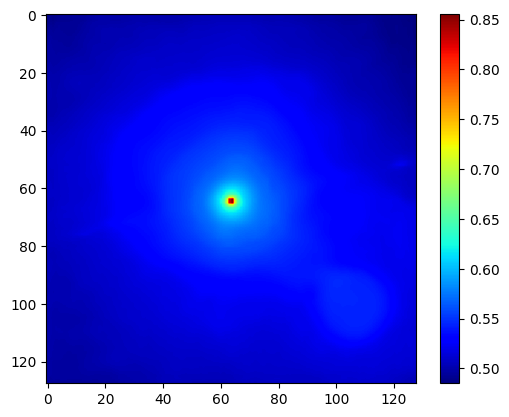

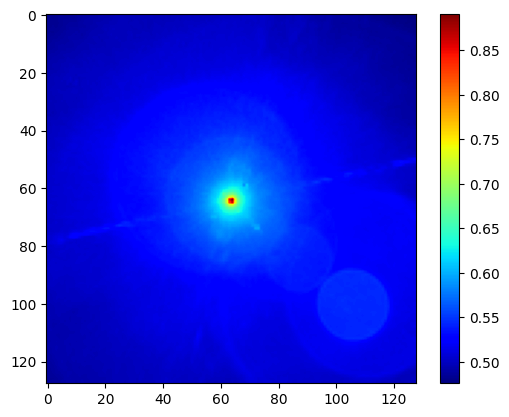

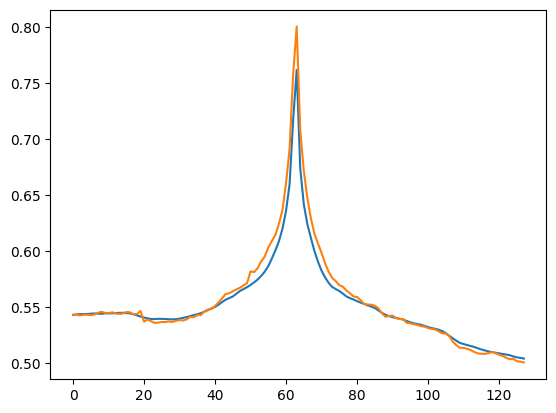

In [52]:
ind = random.randint(0, X_test.shape[0]-1)
pred = unet.predict(X_test[ind:ind+1])
plot_map(pred[0,:,:,0])
plot_map(y_test[ind])
plot_radial_profile([pred[0,:,:,0], y_test[ind]], azimut_test[ind])